# Music Information Retrieval Based On The Free Music Archive Dataset


In [1]:
# Load libraries
%matplotlib inline

import os,IPython
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from librosa.display import waveplot,specshow
from librosa.onset import onset_strength, onset_detect
from librosa.feature import mfcc, spectral_centroid
from librosa.core import zero_crossings
from librosa import load


from collections import OrderedDict
from librosa import load
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
from scipy.stats import kurtosis
from tqdm import tqdm

# Song Extraction from fma_small

1. Find the song folder path relative to the current computer operating system and file structure
2. Identify each song via its full path to song using index to guarantee one-to-one mapping, retrieve the different genre classifications.
3. Retrieve each song via its path and display in 30 second waveform slices
4. Split the song into smaller segments of 3 seconds
5. Retrieve the Time Domain Features
6. Retrieve Frequency Domain Features
7. Combine time and frequency domain features 
8. Retrieve all the aforementioned information in a single function for complete feature extraction
9. Extract features on a song by song basis
10. Use the label encoder to map categorical values to numerical variables
11. Collate all information in a single data frame and save as csv


## 1. This uses the Python Operating System (OS) library to access the file system of the current computer system .This enables the code to be reused without modification for individual computers systems

In [2]:
#retrieving path to the fma_small directory and the corresponding meta data
HOME_DIR = IPython.utils.path.get_home_dir()
temp = join(HOME_DIR, 'Documents')
path_to_small_fma = join(temp, 'fma_small')

#locate meta_data
json_file = join(path_to_small_fma,'fma_small.json')
print(path_to_small_fma)
df = pd.read_json(json_file)
print(json_file)


/home/chib/Documents/fma_small
/home/chib/Documents/fma_small/fma_small.json


## 2. The genres and the train/test split are stored in the the json meta data of the cleaned FMA dataset from the LTS2 lab. This section is used to:
- Retrieve the genre of each song
- Identify whether the song is part of the train or test set for consistent comparison between researches
- Locate the full path of each individual song  

In [3]:
df.shape

(4000, 30)

In [4]:
#only choose top genre as the label
df = df.loc[:,['top_genre','train']]

#ensure that the genre name matches file name in fma_small, 
#i.e Oldtime / Historian conflict issue
df['top_genre']=df['top_genre'].apply(lambda y: y.split(os.sep)[0].strip())
#locate each individual song by its full path
df['temp'] = path_to_small_fma
str_index = ["%.2d" % x for x in df.index]

complete_genre_list_df = pd.DataFrame(df['top_genre'].unique(), columns = ['Genre'])

#create full path to file and store as a single array
df['full_path_to_song'] = df.temp.map(str)+ "/"+ df['top_genre'].values+ "/"+ str_index+ ".mp3"
del df['temp']
#keep songs according to alphabetical order of songs 
df.sort_values(by = 'top_genre', inplace = True)
df.head()


,top_genre,train,full_path_to_song
100538,Electronic,True,/home/chib/Documents/fma_small/Electronic/1005...
43206,Electronic,True,/home/chib/Documents/fma_small/Electronic/4320...
43199,Electronic,True,/home/chib/Documents/fma_small/Electronic/4319...
43153,Electronic,True,/home/chib/Documents/fma_small/Electronic/4315...
43124,Electronic,True,/home/chib/Documents/fma_small/Electronic/4312...


In [5]:
complete_genre_list_df

,Genre
0,Electronic
1,Rock
2,Old-Time
3,Indie-Rock
4,Jazz
5,Folk
6,Pop
7,Psych-Rock
8,Punk
9,Hip-Hop


## 3. Restrict and display example songs in 30 second slices
- Take the shortest length song possible in the dataset and reduce all songs to that length
- Select two songs as demos
- Plot graphs of the signals

In [6]:
#%%timethe
num_of_songs = 3
num_of_mfcc = 12
sampling_rate = 44100
minimum_song_length = 1322496
num_of_songs = df.values.shape[0]
num_of_songs

4000

In [7]:
#this strips the path to up to the genre. The addition of 1 is to include / or \ depending on the OS
word_pos = df['full_path_to_song'].values[0].find("fma_small")+len("fma_small") + 1
base_path = df['full_path_to_song'].values[0][:word_pos]
base_path

'/home/chib/Documents/fma_small/'

In [8]:
#take one electronic song as as example
elec_song_genre = df.iloc[:1,0].values[0]
elec_song_num = df.iloc[:1,0].index[0]
elec_path = base_path+elec_song_genre+"/"+str(elec_song_num)+".mp3"
example_elec = load(elec_path, sr = sampling_rate)[0]
print("The path to this demo electronic song is: %s" % elec_path)
IPython.display.Audio(data= elec_path)


The path to this demo electronic song is: /home/chib/Documents/fma_small/Electronic/100538.mp3


In [9]:
#take one folk song as as example
folk_song_genre = df.iloc[799:800,0].values[0]
folk_song_num = df.iloc[799:800,0].index[0]
folk_path = base_path+folk_song_genre+"/"+str(folk_song_num)+".mp3"
example_folk = load(folk_path, sr = sampling_rate)[0]
print("The path to this demo folk song is: %s" % folk_path)
IPython.display.Audio(data= folk_path)

The path to this demo folk song is: /home/chib/Documents/fma_small/Folk/3631.mp3


## In the figure below each song is displayed in 30 second slices. 

- Minimium Song Length (MSL) = 1322496
- Sampling Rate (SR) = 44100

$$
\begin{align}
Duration = \frac{MSL}{SR} = approximately 30 seconds\\ 
\end{align}
$$


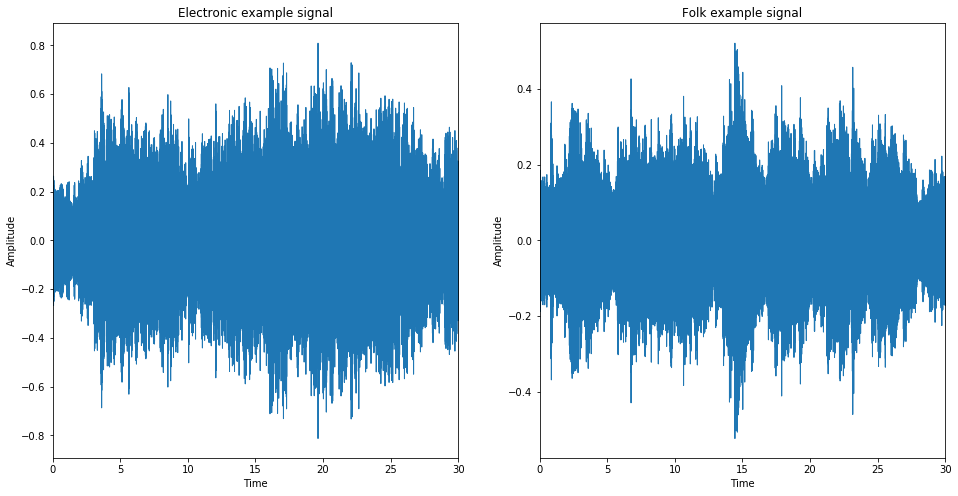

In [10]:
#plot of the electronic and folk songs
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
waveplot(example_elec, sr =sampling_rate,max_points= minimum_song_length)
plt.title(elec_song_genre +" example signal")
plt.ylabel("Amplitude")

plt.subplot(1,2,2)
waveplot(example_folk, sr =sampling_rate, max_points= minimum_song_length)
plt.title(folk_song_genre + " example signal")
plt.ylabel("Amplitude")

## 4. To split the song into different segments
- We take the shortest length song possible in the dataset and reduce all songs to that length
- Break the song into 10 segments of 3 seconds each

In [11]:
default_fft = 2048
#this ensures that the songs are restrict to multiples of librosa defualt fft
demo_length = minimum_song_length-(minimum_song_length%default_fft)

#This differs by one because the fft of odd signals and even signals divers by 1
##_t means used for time domain calculations
demo_elec_song_t = example_elec[:demo_length]
##_f means used for frequency domain calculations
demo_elec_song_f = example_elec[:demo_length-1]

demo_length

1320960

In [12]:
#round the number of frames to the nearest 10 below it
num_of_frames  = int(demo_length/default_fft) - int(demo_length/default_fft)%10
num_of_frames

640

In [13]:
#the number of frames will always be a factor of 2048 and in addition 5,10 since it ends is rounded to nearest 10
segments_list = [1,2,4,5,8,10]
#setting the number of segments to 10
num_of_segments = segments_list[-1]
num_of_segments

10

In [14]:
num_of_frames_per_segment = int(num_of_frames/num_of_segments)
num_of_frames_per_segment

64

In [15]:
#takes into account the fact that librosa hop width is a quarter of the default fft width
num_of_subframes = int(np.floor((minimum_song_length*4)/default_fft))
num_of_subframes_per_segment = int(num_of_subframes/num_of_segments)
num_of_subframes_per_segment


258

In [16]:
#change structure to per song segment rather than per song
ind_song_into_segment = int(demo_length/num_of_segments)
song_into_segments = np.reshape(demo_elec_song_t,(num_of_segments, ind_song_into_segment))
song_into_segments.shape

(10, 132096)

# 5. Computing  Time Domain Features

- 
### Zero Crossing Rate (ZCR) 
- 
### Onsets 

## Zero Crossings is the number of times that the song signals crosses the axis. 
- The librosa zero crossings function returns binary values, showing whether or not the song signal crossed the axis
- The summation is across binary values to used to count the number of zero crossings
- Reshape dependent on the number of segments

In [17]:
zcr_features_per_segment = np.sum(zero_crossings(song_into_segments),axis = 1) 
#zero crossings returns boolean values, so summation only adds True values together
zcr_features_per_segment = np.reshape(zcr_features_per_segment,(zcr_features_per_segment.shape[0],1))
#retrieve the number of zero crossings in each song segment
for i in range (num_of_segments):
    print("Segment %d: has %d zero crossings"%(i+1,zcr_features_per_segment[i]))

zcr_features_per_segment.shape

Segment 1: has 2157 zero crossings
Segment 2: has 2570 zero crossings
Segment 3: has 3143 zero crossings
Segment 4: has 5374 zero crossings
Segment 5: has 5665 zero crossings
Segment 6: has 4233 zero crossings
Segment 7: has 4821 zero crossings
Segment 8: has 4983 zero crossings
Segment 9: has 3981 zero crossings
Segment 10: has 6495 zero crossings


(10, 1)

# Onsets show the transients in a songs. 
- Locate the position of the onsets 
- Calculate the number of onsets in each segment


In [18]:
#retrive the index locations where onsets are
onset_frames = onset_detect(y=demo_elec_song_t, sr=sampling_rate, units='samples')
onset_length = len(onset_frames)
onset_frames

array([   1536,   12800,   20992,   34816,   45056,   68096,   83456,
         90112,   97792,  111104,  132608,  153600,  170496,  175104,
        178176,  192512,  198144,  200192,  221184,  264192,  286720,
        288768,  309248,  332288,  342016,  354304,  375296,  396800,
        416256,  425984,  430592,  442368,  463872,  472064,  484352,
        485888,  501248,  508416,  523776,  529920,  551424,  567808,
        573440,  581632,  588288,  595456,  614912,  651776,  696320,
        751104,  770560,  773632,  794112,  811520,  817152,  825856,
        837120,  861696,  871424,  877056,  895488,  906240,  922624,
        950272,  962048,  966144,  967680,  972288, 1010688, 1025024,
       1032704, 1052160, 1078784, 1100800, 1123328, 1144832, 1164800,
       1168896, 1170432, 1188352, 1213440, 1233408, 1235456, 1247744,
       1256960, 1261568, 1263104, 1276928, 1279488, 1287680, 1292800,
       1302016, 1316352])

In [19]:
#these are index location that split the song equally into 10 parts/segments
song_splitter = np.arange(0,len(demo_elec_song_t)+1, ind_song_into_segment,dtype=int)
split_length = len(song_splitter)
song_splitter

array([      0,  132096,  264192,  396288,  528384,  660480,  792576,
        924672, 1056768, 1188864, 1320960])

In [20]:
total_onsets = [0]
for i in range(1,split_length):
    total_onsets.append(np.sum(onset_frames<song_splitter[i]))

total_onsets

[0, 10, 19, 27, 39, 48, 52, 63, 72, 80, 93]

In [21]:
#the difference is taken to retrieve the onsets on a per segment basis rather
#than a commulative sum of the number of segments
total_onset_diff = np.diff(total_onsets)
onsets_features_per_segment = np.reshape(total_onset_diff,(len(total_onset_diff),1))
for i in range (num_of_segments):
    print("Segment number %d: has %d onsets"%(i+1,onsets_features_per_segment[i]))

onsets_features_per_segment.shape

Segment number 1: has 10 onsets
Segment number 2: has 9 onsets
Segment number 3: has 8 onsets
Segment number 4: has 12 onsets
Segment number 5: has 9 onsets
Segment number 6: has 4 onsets
Segment number 7: has 11 onsets
Segment number 8: has 9 onsets
Segment number 9: has 8 onsets
Segment number 10: has 13 onsets


(10, 1)

In [22]:
time_domain_features_per_segment = np.concatenate((zcr_features_per_segment,onsets_features_per_segment),axis =1)
print("The size of the time domain feature dataframe is: %s"% str(time_domain_features_per_segment.shape))
time_domain_features_per_segment

The size of the time domain feature dataframe is: (10, 2)


array([[2157,   10],
       [2570,    9],
       [3143,    8],
       [5374,   12],
       [5665,    9],
       [4233,    4],
       [4821,   11],
       [4983,    9],
       [3981,    8],
       [6495,   13]])

# 6. Computing  Frequency Domain Features


- ### Mel-Frequency Cepstral Coefficients (MFCC) 
- 
### Spectal Centroid

## Mel-Frequency Cepstral Coefficients (MFCC) 
- Split the song into smaller frames. The assumption is that the signal is statistically stationary (moments like mean, variance are constant over time) during the frame
 .(s)
- Take the power spectrum of each frame to identify its frequency contents
- Mel Filterbanks are used to ascern the difference between two closely spaced frequencies. These are the filterbank energies.
- Take the logarithm of the filterbank energies as the human ear hears sound logarithmically rather than linearly
- Calculate the Cepstral Coefficients by taking the Discrete Cosine Transform (DCT) of the log filter bank energies. 
- Calculate statistical moments such as mean, variance, skew and kurtosis on each song segment

Source: http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

In [23]:
#this calculates mfcc for individual song, so it is reshaped for song segments 
mfcc_per_segment = mfcc(y=demo_elec_song_f, sr=sampling_rate,
                                     n_mfcc=num_of_mfcc).T
mfcc_per_segment = np.reshape(mfcc_per_segment,(num_of_subframes_per_segment,num_of_segments,num_of_mfcc))
mfcc_per_segment.shape

(258, 10, 12)

In [24]:
#calculating the statistical moments for each mfcc song segment
mean_mfcc_per_segment = np.mean(mfcc_per_segment,axis = 0)
var_mfcc_per_segment = np.var(mfcc_per_segment, axis = 0)
skew_mfcc_per_segment = skew(mfcc_per_segment,axis = 0)
kurtosis_mfcc_per_segment = kurtosis(mfcc_per_segment,axis = 0)

mfcc_features_per_segment = np.concatenate((mean_mfcc_per_segment,var_mfcc_per_segment,skew_mfcc_per_segment,kurtosis_mfcc_per_segment),axis =1)

mfcc_features_per_segment.shape

(10, 48)

## Spectral Centroid indicates where the "centre of mass" of the spectrum is located. It is the weighted mean of the frequencies present in the s
- f[n] represents the center frequency of that bin
- x[n] is the weight for the frequency value. It represents the amplitude/magnitude of frequency values at the nth bin
 
$$
\begin{align}
Spectral Centroid = \frac{\sum\limits_{n=0}^{N-1}f[n]x[n]}{\sum\limits_{n=0}^{N-1}x[n]}
\end{align}
$$

Source: https://ccrma.stanford.edu/~unjung/AIR/areaExam.pdf

- Reshape the song based on the number of song segments 
- Calculate statistical moments such as mean, variance, skew and kurtosis on each song segment


In [25]:
#this calculates spectral centroid for individual song, so it is reshaped for song segments 
spectral_centroid_feat = spectral_centroid(y=demo_elec_song_f, sr=sampling_rate).T

spc_per_segment = np.reshape(spectral_centroid_feat, (num_of_segments,num_of_subframes_per_segment))
spc_per_segment.shape

(10, 258)

In [26]:
#calculating the spectral centroid for each spc song segment
mean_spc_per_segment = np.mean(spc_per_segment,axis=1)
mean_spc_per_segment = np.reshape(mean_spc_per_segment,(len(mean_spc_per_segment),1))
var_spc_per_segment = np.var(spc_per_segment,axis =1)
var_spc_per_segment = np.reshape(var_spc_per_segment,(len(var_spc_per_segment),1))
skew_spc_per_segment = skew(spc_per_segment,axis =1)
skew_spc_per_segment = np.reshape(skew_spc_per_segment,(len(skew_spc_per_segment),1))
kurtosis_spc_per_segment = kurtosis(spc_per_segment,axis =1)
kurtosis_spc_per_segment = np.reshape(kurtosis_spc_per_segment,(len(kurtosis_spc_per_segment),1))

spc_features_per_segment = np.concatenate((mean_spc_per_segment,var_spc_per_segment,skew_spc_per_segment,kurtosis_spc_per_segment),axis = 1)

spc_features_per_segment.shape

(10, 4)

In [27]:
freq_domain_features_per_segment = np.concatenate((mfcc_features_per_segment,spc_features_per_segment),axis =1)
print("The size of the frequency domain feature dataframe is: %s"% str(freq_domain_features_per_segment.shape))
freq_domain_features_per_segment

The size of the frequency domain feature dataframe is: (10, 52)


array([[ -1.60973272e+02,   1.84320385e+02,  -2.29853950e+01,
          3.95274036e+01,  -9.81377033e+00,   1.53105254e+01,
         -1.38438774e+01,   1.78040837e+01,   8.59484080e-01,
         -4.56700775e+00,  -1.29546862e+00,  -4.09101433e+00,
          3.14485701e+03,   3.01407532e+02,   4.86235149e+02,
          2.23927747e+02,   1.78135580e+02,   1.22738031e+02,
          9.07619591e+01,   4.29517409e+01,   5.31468967e+01,
          4.68501286e+01,   2.83090874e+01,   3.24989164e+01,
         -2.06596522e+00,  -1.67728088e+00,   1.64835376e+00,
         -2.36482298e-02,   6.14262830e-02,   3.80413466e-01,
          4.88822685e-01,  -2.98513383e-02,  -1.87160192e-01,
          2.67115608e-01,   2.12143279e-02,   4.62938582e-01,
          4.90782697e+00,   3.68741130e+00,   3.67588500e+00,
          9.90522415e-01,   2.87604783e-01,  -1.79820699e-02,
          2.92105871e-01,   4.47395553e-01,   8.61368121e-01,
         -2.20679161e-01,   2.44653154e-02,   1.19702724e+00,
        

# 7. Combine the Time and Frequency Domain Features


In [28]:
features_per_segment= np.concatenate((time_domain_features_per_segment,freq_domain_features_per_segment),axis =1)
feature_mfcc = ["Zero Crossing Rate","Number of Onsets","mfcc_mean_","mfcc_var_","mfcc_skew_","mfcc_kurtosis_","spectral_centroid_mean","spectral_centroid_var","spectral_centroid_skew","spectral_centroid_kurtosis"]

feature_cols = []
num_of_mfcc = 12

for name in feature_mfcc:
    if name[:4] == "mfcc":
        for i in range(1,num_of_mfcc+1): 
            feature_cols.append(name+str(i))
    else:
        feature_cols.append(name)
        
        
complete_extract_df = pd.DataFrame(data = features_per_segment,columns=feature_cols)
complete_extract_df

,Zero Crossing Rate,Number of Onsets,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,mfcc_kurtosis_7,mfcc_kurtosis_8,mfcc_kurtosis_9,mfcc_kurtosis_10,mfcc_kurtosis_11,mfcc_kurtosis_12,spectral_centroid_mean,spectral_centroid_var,spectral_centroid_skew,spectral_centroid_kurtosis
0,2157.0,10.0,-160.973272,184.320385,-22.985395,39.527404,-9.813770,15.310525,-13.843877,17.804084,...,0.292106,0.447396,0.861368,-0.220679,0.024465,1.197027,968.625640,275094.428012,1.173542,1.921552
1,2570.0,9.0,-160.344057,184.074794,-23.322441,39.534971,-9.647739,15.304824,-13.893123,18.174114,...,0.908857,0.938244,0.400142,-0.264739,0.071246,0.939847,1270.389393,17999.842129,0.596692,0.692742
2,3143.0,8.0,-160.058394,183.666478,-23.374013,39.374805,-10.326398,15.310107,-13.971265,17.986350,...,1.220102,0.285930,1.038080,0.110875,-0.089481,0.362001,1561.206407,160435.404399,1.592194,2.524688
3,5374.0,12.0,-159.891569,183.892191,-22.914240,39.327850,-10.551005,15.471867,-14.188831,17.773913,...,0.853744,0.224956,1.440948,-0.204822,-0.159536,0.222453,1834.602074,395308.340084,4.248760,17.500982
4,5665.0,9.0,-159.699858,184.313259,-23.128340,39.072852,-10.387527,15.084918,-14.113351,17.761934,...,0.965512,0.025239,1.023522,0.284749,-0.282557,0.697686,2275.671978,419006.552103,1.792972,3.456450
5,4233.0,4.0,-160.589245,183.759895,-23.468740,39.312662,-10.234623,15.016939,-14.151684,17.522570,...,1.300793,0.168306,1.152630,-0.091316,-0.310369,0.003197,1809.791628,161102.086831,1.506138,2.491702
6,4821.0,11.0,-160.895901,183.915729,-23.325363,39.476560,-10.075741,15.213195,-14.231476,17.504163,...,0.566000,0.045510,1.336216,-0.256187,0.108071,-0.085270,2009.890048,675295.243375,2.075374,3.444626
7,4983.0,9.0,-160.699118,184.131995,-23.627454,39.175700,-9.998731,15.218191,-14.267469,17.632736,...,0.660986,-0.123903,0.560365,0.140867,0.028676,-0.283043,2059.340694,201868.693865,1.439725,2.127228
8,3981.0,8.0,-160.447509,184.006099,-23.931341,39.172532,-9.926407,15.136880,-13.970451,17.717359,...,0.473093,0.132468,0.553292,-0.040837,0.373075,-0.273164,1652.638550,89947.499656,2.369875,7.694625
9,6495.0,13.0,-160.260212,183.769066,-23.758201,39.398229,-9.964494,15.251964,-14.074251,17.797812,...,0.582334,0.284120,0.677287,-0.228240,0.183637,-0.198983,2109.934419,476283.345930,2.203267,5.244489


# 8. Single function to put together all the piecewise steps above for feature extraction

In [29]:
def complete_feature_extraction(song_t,song_f,song_genre):
    song_into_segments = np.reshape(demo_elec_song_t,(num_of_segments, ind_song_into_segment))

    #compute time domain features    
    zcr_features_per_segment = np.sum(zero_crossings(song_into_segments),axis = 1) #zero crossings returns boolean values
    zcr_features_per_segment = np.reshape(zcr_features_per_segment,(zcr_features_per_segment.shape[0],1))

    onset_frames = onset_detect(y=curr_song_t, sr=sampling_rate, units='samples')
    total_onsets = [0]
    for i in range(1,split_length):
        total_onsets.append(np.sum(onset_frames<song_splitter[i]))
    total_onset_diff = np.diff(total_onsets)
    onsets_features_per_segment = np.reshape(total_onset_diff,(len(total_onset_diff),1))



    mfcc_per_segment = mfcc(y=curr_song_f, sr=sampling_rate,
                                     n_mfcc=num_of_mfcc).T
    mfcc_per_segment = np.reshape(mfcc_per_segment,(num_of_subframes_per_segment,num_of_segments,num_of_mfcc))
    mean_mfcc_per_segment = np.mean(mfcc_per_segment,axis = 0)

    var_mfcc_per_segment = np.var(mfcc_per_segment, axis = 0)
    skew_mfcc_per_segment = skew(mfcc_per_segment,axis = 0)
    kurtosis_mfcc_per_segment = kurtosis(mfcc_per_segment,axis = 0)

    mfcc_features_per_segment = np.concatenate((mean_mfcc_per_segment,var_mfcc_per_segment,skew_mfcc_per_segment,kurtosis_mfcc_per_segment),axis =1)


    spectral_centroid_feat = spectral_centroid(y=demo_elec_song_f, sr=sampling_rate).T
    spc_per_segment = np.reshape(spectral_centroid_feat, (num_of_segments,num_of_subframes_per_segment))

    mean_spc_per_segment = np.mean(spc_per_segment,axis=1)
    mean_spc_per_segment = np.reshape(mean_spc_per_segment,(len(mean_spc_per_segment),1))
    var_spc_per_segment = np.var(spc_per_segment,axis =1)
    var_spc_per_segment = np.reshape(var_spc_per_segment,(len(var_spc_per_segment),1))
    skew_spc_per_segment = skew(spc_per_segment,axis =1)
    skew_spc_per_segment = np.reshape(skew_spc_per_segment,(len(skew_spc_per_segment),1))
    kurtosis_spc_per_segment = kurtosis(spc_per_segment,axis =1)
    kurtosis_spc_per_segment = np.reshape(kurtosis_spc_per_segment,(len(kurtosis_spc_per_segment),1))

    complete_features_per_segment = np.concatenate((zcr_features_per_segment,onsets_features_per_segment, mean_mfcc_per_segment,var_mfcc_per_segment,skew_mfcc_per_segment,kurtosis_mfcc_per_segment, mean_spc_per_segment,var_spc_per_segment,skew_spc_per_segment,kurtosis_spc_per_segment),axis = 1)
    return complete_features_per_segment

    
    
    

# 9. Perform feature extraction on each individual song

In [30]:
%%time
total_features_df = np.zeros((int(num_of_songs*num_of_segments),complete_extract_df.shape[1]))

#tqdm is used to show the progress loading bar

for i in tqdm(range(num_of_songs),desc= "Loading songs"):
    try:
        #curr variables are used to retrieve from the current song in the dataframe
        curr_song = load(df['full_path_to_song'].values[i],sr = sampling_rate)[0][:minimum_song_length]
        curr_song_t = curr_song[:demo_length]
        curr_song_f = curr_song[:(demo_length-1)]
        curr_genre = df['top_genre'].values[i]
          
        #retrieve all features    
        output = complete_feature_extraction(curr_song_t,curr_song_f,curr_genre)
        #e
        total_features_df[i*num_of_segments:(num_of_segments*i)+num_of_segments,:] = output

    except:        
        print("There was an error whilst computing the features for song number:  %d " % i)
    

 

 


Loading songs:  24%|██▎       | 944/4000 [17:51<1:14:24,  1.46s/it]

There was an error whilst computing the features for song number:  943 


Loading songs:  29%|██▊       | 1148/4000 [21:51<1:04:01,  1.35s/it]

There was an error whilst computing the features for song number:  1148 


Loading songs: 100%|██████████| 4000/4000 [1:05:11<00:00,  1.44it/s]

CPU times: user 1h 55s, sys: 39min 59s, total: 1h 40min 54s
Wall time: 1h 5min 11s


# 10. Label Encoder to map categorical variables to numerical variables

In [31]:
le = LabelEncoder()
genres= np.repeat(df['top_genre'].values,num_of_segments,axis=0)
encoded_genres= le.fit(genres)
train_labels = np.repeat((df['train'].values),num_of_segments,axis =0)
encoded_genres

#Label Encoding Mapping
encoder_df= pd.DataFrame(data= {'Genre':genres,
                   'Encoded_Genre':le.transform(genres),
                               'Train': train_labels}, 
                         index = np.repeat(df.index.values,num_of_segments,axis=0) )
encoder_df.head()




,Encoded_Genre,Genre,Train
100538,0,Electronic,True
100538,0,Electronic,True
100538,0,Electronic,True
100538,0,Electronic,True
100538,0,Electronic,True


# 11. Collate all the Time and Frequency Domain Information and Label Encoding Information into a single file ready for analysis and machine learning

In [32]:
total_features_df = pd.DataFrame(data = total_features_df,columns=feature_cols)
total_features_df.head()

,Zero Crossing Rate,Number of Onsets,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,mfcc_kurtosis_7,mfcc_kurtosis_8,mfcc_kurtosis_9,mfcc_kurtosis_10,mfcc_kurtosis_11,mfcc_kurtosis_12,spectral_centroid_mean,spectral_centroid_var,spectral_centroid_skew,spectral_centroid_kurtosis
0,2157.0,10.0,-160.973272,184.320385,-22.985395,39.527404,-9.813770,15.310525,-13.843877,17.804084,...,0.292106,0.447396,0.861368,-0.220679,0.024465,1.197027,968.625640,275094.428012,1.173542,1.921552
1,2570.0,9.0,-160.344057,184.074794,-23.322441,39.534971,-9.647739,15.304824,-13.893123,18.174114,...,0.908857,0.938244,0.400142,-0.264739,0.071246,0.939847,1270.389393,17999.842129,0.596692,0.692742
2,3143.0,8.0,-160.058394,183.666478,-23.374013,39.374805,-10.326398,15.310107,-13.971265,17.986350,...,1.220102,0.285930,1.038080,0.110875,-0.089481,0.362001,1561.206407,160435.404399,1.592194,2.524688
3,5374.0,12.0,-159.891569,183.892191,-22.914240,39.327850,-10.551005,15.471867,-14.188831,17.773913,...,0.853744,0.224956,1.440948,-0.204822,-0.159536,0.222453,1834.602074,395308.340084,4.248760,17.500982
4,5665.0,9.0,-159.699858,184.313259,-23.128340,39.072852,-10.387527,15.084918,-14.113351,17.761934,...,0.965512,0.025239,1.023522,0.284749,-0.282557,0.697686,2275.671978,419006.552103,1.792972,3.456450


In [33]:
total_features_df.shape

(40000, 54)

In [34]:
encoder_df.shape

(40000, 3)

In [35]:
final_col = np.concatenate((total_features_df.columns.values,encoder_df.columns.values))
final_col

array(['Zero Crossing Rate', 'Number of Onsets', 'mfcc_mean_1',
       'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5',
       'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9',
       'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12', 'mfcc_var_1',
       'mfcc_var_2', 'mfcc_var_3', 'mfcc_var_4', 'mfcc_var_5',
       'mfcc_var_6', 'mfcc_var_7', 'mfcc_var_8', 'mfcc_var_9',
       'mfcc_var_10', 'mfcc_var_11', 'mfcc_var_12', 'mfcc_skew_1',
       'mfcc_skew_2', 'mfcc_skew_3', 'mfcc_skew_4', 'mfcc_skew_5',
       'mfcc_skew_6', 'mfcc_skew_7', 'mfcc_skew_8', 'mfcc_skew_9',
       'mfcc_skew_10', 'mfcc_skew_11', 'mfcc_skew_12', 'mfcc_kurtosis_1',
       'mfcc_kurtosis_2', 'mfcc_kurtosis_3', 'mfcc_kurtosis_4',
       'mfcc_kurtosis_5', 'mfcc_kurtosis_6', 'mfcc_kurtosis_7',
       'mfcc_kurtosis_8', 'mfcc_kurtosis_9', 'mfcc_kurtosis_10',
       'mfcc_kurtosis_11', 'mfcc_kurtosis_12', 'spectral_centroid_mean',
       'spectral_centroid_var', 'spectral_centroid_skew',
       '

In [36]:
finished_df = pd.DataFrame(data = np.concatenate((total_features_df.values,encoder_df.values),axis=1), columns=final_col)
finished_df.head()

,Zero Crossing Rate,Number of Onsets,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,mfcc_kurtosis_10,mfcc_kurtosis_11,mfcc_kurtosis_12,spectral_centroid_mean,spectral_centroid_var,spectral_centroid_skew,spectral_centroid_kurtosis,Encoded_Genre,Genre,Train
0,2157,10,-160.973,184.32,-22.9854,39.5274,-9.81377,15.3105,-13.8439,17.8041,...,-0.220679,0.0244653,1.19703,968.626,275094,1.17354,1.92155,0,Electronic,True
1,2570,9,-160.344,184.075,-23.3224,39.535,-9.64774,15.3048,-13.8931,18.1741,...,-0.264739,0.0712459,0.939847,1270.39,17999.8,0.596692,0.692742,0,Electronic,True
2,3143,8,-160.058,183.666,-23.374,39.3748,-10.3264,15.3101,-13.9713,17.9863,...,0.110875,-0.0894815,0.362001,1561.21,160435,1.59219,2.52469,0,Electronic,True
3,5374,12,-159.892,183.892,-22.9142,39.3278,-10.551,15.4719,-14.1888,17.7739,...,-0.204822,-0.159536,0.222453,1834.6,395308,4.24876,17.501,0,Electronic,True
4,5665,9,-159.7,184.313,-23.1283,39.0729,-10.3875,15.0849,-14.1134,17.7619,...,0.284749,-0.282557,0.697686,2275.67,419007,1.79297,3.45645,0,Electronic,True


In [37]:
finished_df.to_csv("CompleteFeatureExtraction.csv",sep=',')